In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster import hierarchy
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from itertools import product
import warnings
import statsmodels.api as sm
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\v_rusakevich\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Считывание датасета и просмотр статистик

##### Датасет потребления электроэнергии по одной минуте в течение почти 4-х лет.

In [2]:
df = pd.read_csv('household_power_consumption.zip', sep=';', compression='zip')

In [3]:
# Датасет содержит "числовые" и разделенные признаки "даты" и "времени", которые, как увидим далее, на самом деле object
df.head(10)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
5,16/12/2006,17:29:00,3.520,0.522,235.020,15.000,0.000,2.000,17.0
6,16/12/2006,17:30:00,3.702,0.520,235.090,15.800,0.000,1.000,17.0
7,16/12/2006,17:31:00,3.700,0.520,235.220,15.800,0.000,1.000,17.0
8,16/12/2006,17:32:00,3.668,0.510,233.990,15.800,0.000,1.000,17.0
9,16/12/2006,17:33:00,3.662,0.510,233.860,15.800,0.000,2.000,16.0


In [4]:
# Кроме одного признака "Sub_metering_3", все определелись как категориальные
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
Date                     object
Time                     object
Global_active_power      object
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           object
Sub_metering_2           object
Sub_metering_3           float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [5]:
# Всем числовым признакам присвоим соответствующий формат, а дату и время объединим и присвоим datetime,
# кроме того датасет содержит более 2млн строк, где одна строка - это одна минута, 
# поэтому сгруппируем данные до диапозона в один час. Это сократит выборку до 35тыс, что на порядок ускорит кластеризацию,
# при этом информативность датасета должна сохраниться.

num_col = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
               'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'] # числовые признаки

# Класс препроцессинга - группировка данных и приведение признаков к необходимому формату
class Group():
    def __init__(self, num_col):
        self.num_col = num_col
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        self.X = X
        self.X['datetime'] = self.X.apply(lambda x: pd.to_datetime('{} {}'.format(x.Date, x.Time)), axis=1)
        self.X['datetime'] = self.X['datetime'].dt.floor('1h')
        self.X[self.num_col] = self.X[self.num_col].apply(pd.to_numeric, errors='coerce')
        self.data_new = self.X.groupby('datetime')[self.num_col].sum() 
        return self.data_new

In [6]:
group = Group(num_col)  # экземпляр группировки датасета
scaler = StandardScaler() # экземпляр нормализатора данных

prep = Pipeline([
    ("group", group),
    ('scaler', scaler)
])

# размер получившейся таблицы
prep.fit_transform(df).shape

(34589, 7)

In [7]:
# добавляем в pipeline по умолчанию KMeans
KM = KMeans()
pipe = Pipeline([
    ("preprocessing", prep),
    ("modelling", KM)
])
# посмотрим какие параметры есть у pipeline
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'modelling', 'preprocessing__memory', 'preprocessing__steps', 'preprocessing__verbose', 'preprocessing__group', 'preprocessing__scaler', 'preprocessing__scaler__copy', 'preprocessing__scaler__with_mean', 'preprocessing__scaler__with_std', 'modelling__algorithm', 'modelling__copy_x', 'modelling__init', 'modelling__max_iter', 'modelling__n_clusters', 'modelling__n_init', 'modelling__n_jobs', 'modelling__precompute_distances', 'modelling__random_state', 'modelling__tol', 'modelling__verbose'])

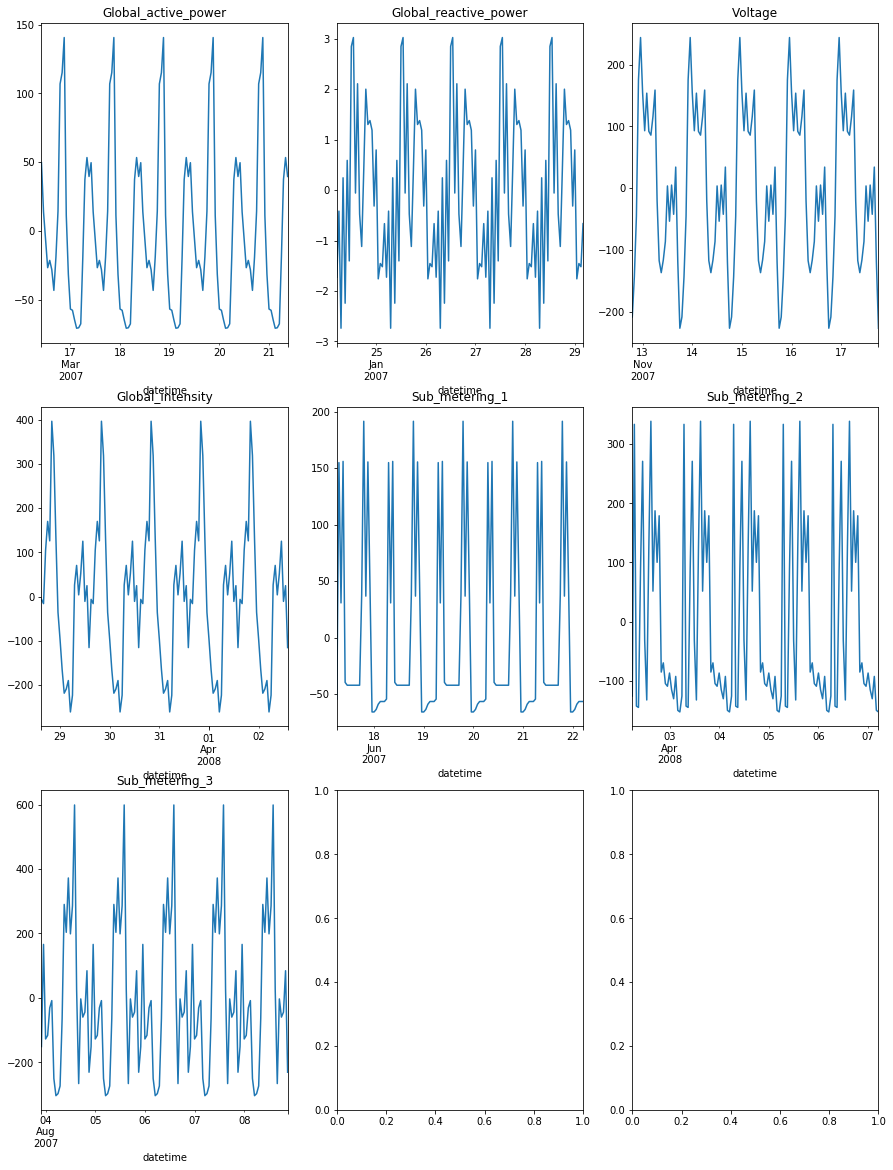

In [8]:
# Не углубляясь в подробности, посмотрим лишь на наличие сезонности данных по всем признакам - 
# выберем случайным образом участки в датасете.
# Видно, что сезонность явно присустствует и соответствует 24 часам - суткам,
# что довольно логично - электричество потребляют в зависимости от времени суток,
# поэтому после группировки данных информативность датасета осталась, 
# закономерности данныe не потеряли, можно попытаться кластеризовать.
pipe.set_params(preprocessing__scaler = 'passthrough') # пропустим нормализатор
df_group = pipe['preprocessing'].fit_transform(df)

fig, axs = plt.subplots(3, 3, figsize=(15, 20))
j = 0
for i in num_col:
    r = np.random.random_integers(0,30000)
    ax = axs[j//3,j%3]
    sm.tsa.seasonal_decompose(df_group[i][r:r+120]).seasonal.plot(ax=ax)
    ax.set_title(i)
    j += 1
plt.show()

In [9]:
# Теперь посмотрим на основные статистики признаков
df_group.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000
mean,64.674459,7.329660,14268.938222,274.178918,66.470121,76.932869,382.640926
std,53.995513,4.066808,1608.365811,226.097083,211.089850,250.148948,440.306805
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.218000,4.618000,14344.730000,89.400000,0.000000,0.000000,38.000000
50%,46.948000,6.364000,14455.770000,200.400000,0.000000,19.000000,99.000000
75%,94.206000,8.920000,14560.290000,393.800000,0.000000,39.000000,837.000000
max,393.632000,46.460000,15114.120000,1703.000000,2902.000000,2786.000000,1293.000000


In [10]:
# Пропусков нет
df_group.isnull().sum().sort_values(ascending=False)

Sub_metering_3           0
Sub_metering_2           0
Sub_metering_1           0
Global_intensity         0
Voltage                  0
Global_reactive_power    0
Global_active_power      0
dtype: int64

Wall time: 173 ms


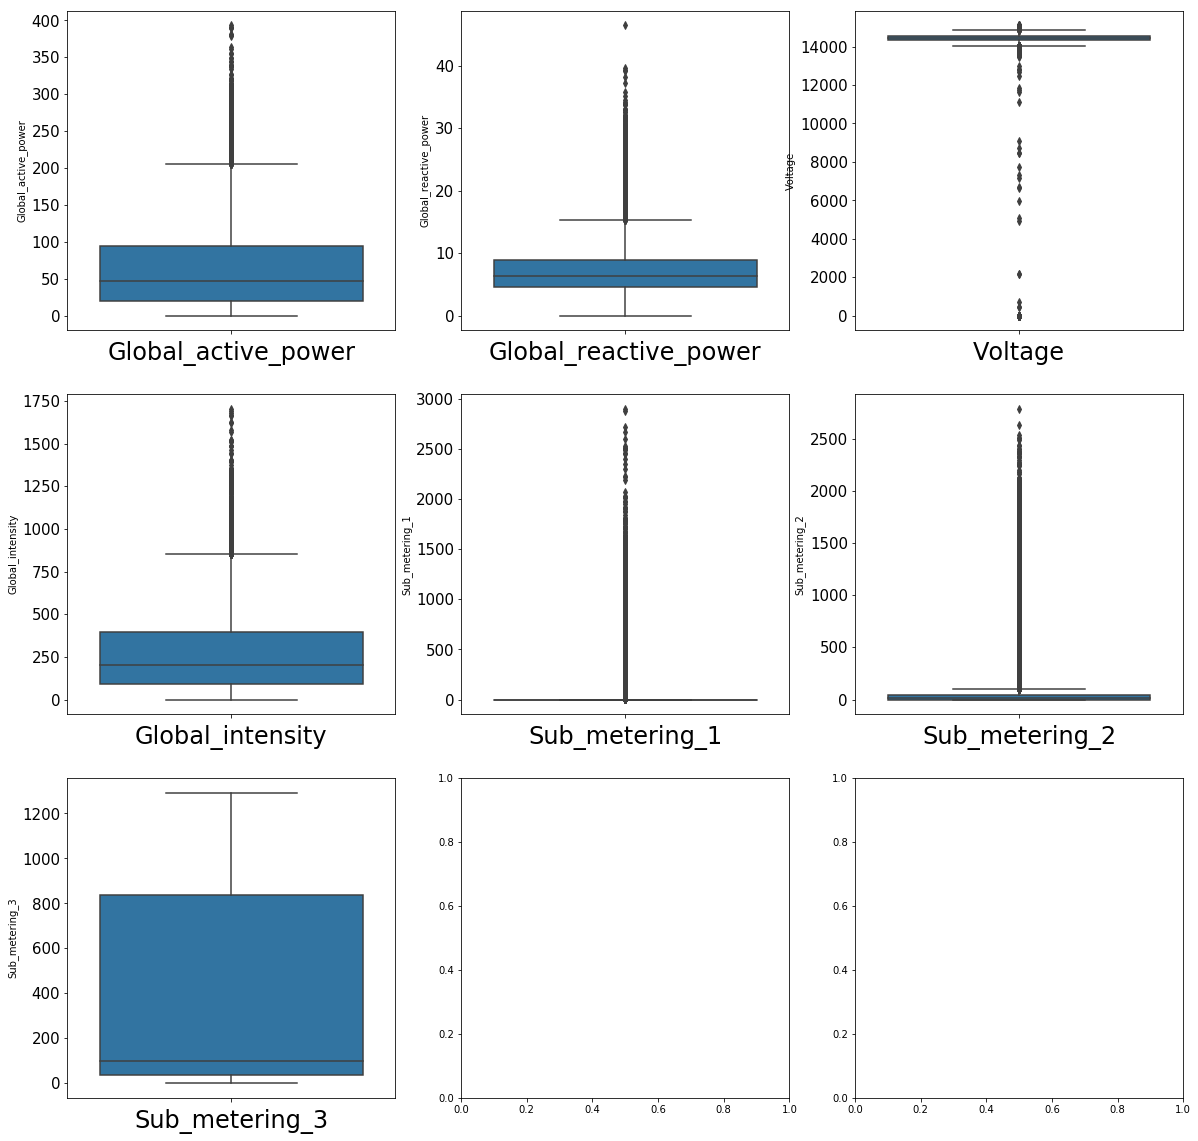

In [11]:
%%time
# Посмотрим распределение признаков 
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
j = 0
for i in df_group.columns:
    ax = axs[j//3,j%3]
    ax= sns.boxplot(y=i, ax=ax, data=df_group)
    ax.set_xlabel(i, size=24) 
    ax.tick_params(labelsize=15)
    j += 1
# Видим, что во-первых масштаб между ними сильно отличается, т.е нужно нормализовывать.
# Также некоторые признаки очень смещены в сторону узкого диапазона значений, 
# например - Sub_metering_1 - большинство значений нули, 
# Кроме этого у всех признаков, много выбросов, 
# посмотрим позже, как их будет кластеризовать DBSCAN - какую долю выбросов он посчитает в зависимости от своих параметров

In [12]:
%%time
# Для ускорения процесса подбора количества кластеров в моделях создадим заранее сгруппированный и нормализованный датасет,
# на котором далее будем обучать модели. Т.к. процесс обработки 2млн. строк занимает значительное время,
# и гонять его постоянно в циклах очень не разумно.
pipe.set_params(preprocessing__scaler = scaler) # установим нормализатор обратно
df_group = pipe['preprocessing'].fit_transform(df)

Wall time: 11min 3s


## Сделаем кластеризацию с помощью алгоритмов - KMeans, Иерархической (AgglomerativeClustering) и DBSCAN, и подберем оптимальное количество кластеров.

##### Kmeans:

In [13]:
%%time
# Подберем на основе silhouette и inertia количество кластеров
K = range(2,21)
inertia = []
silhouette = []

for i in K: # переберем разное количество кластеров и соберем метрики inertia и силуэта
    pipe['modelling'].set_params(n_clusters=i).fit(df_group)
    inertia.append(pipe['modelling'].inertia_)
    silhouette.append(silhouette_score(df_group, pipe['modelling'].labels_))

Wall time: 6min 15s


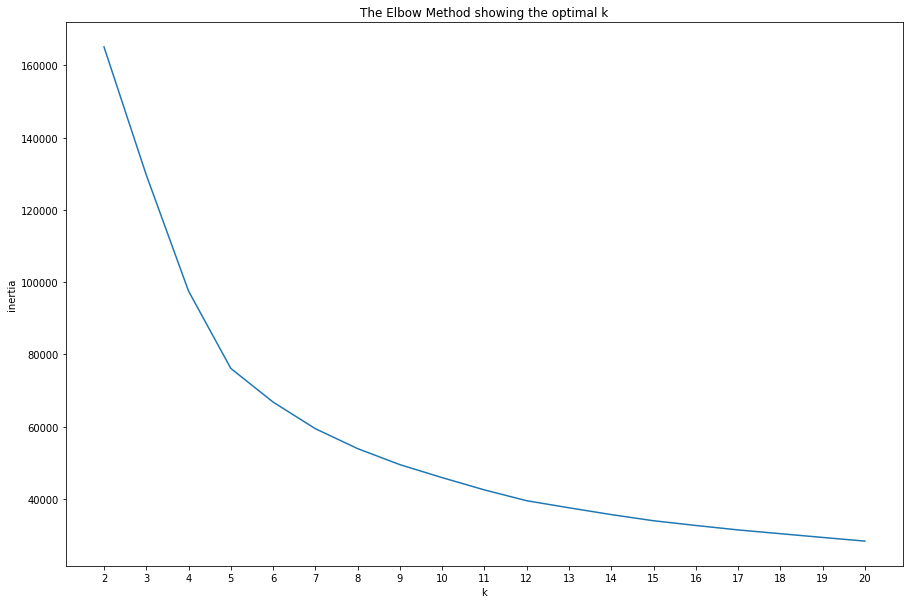

In [14]:
# По inertia идет постепенное убывание, не опередилть оптимально число кластеров
plt.figure(figsize=(15,10))
plt.plot(K, inertia)
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k')
plt.xticks(K)
plt.show()

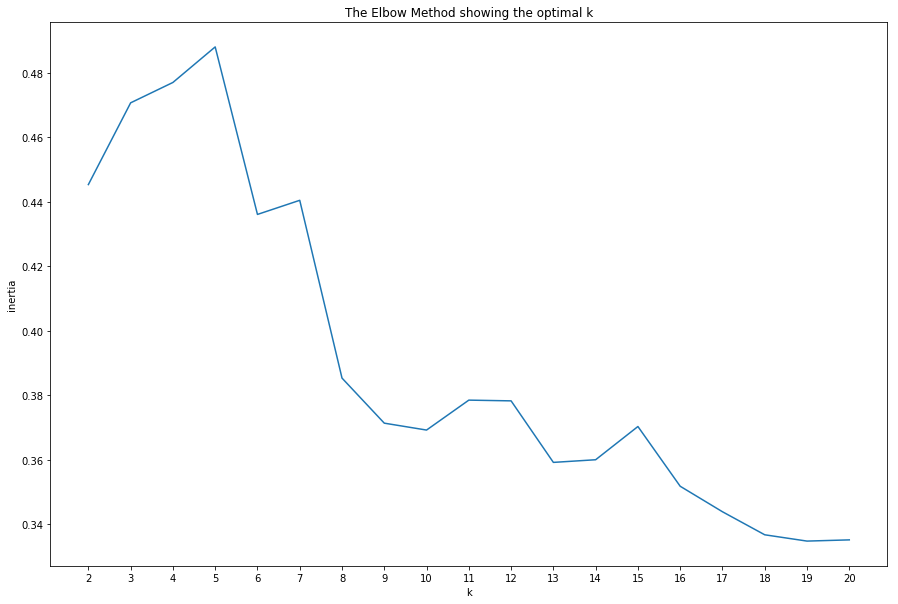

In [15]:
# По силуэту либо 5, либо 7 кластеров - происходит резкое уменьшение показателя силуэта
plt.figure(figsize=(15,10))
plt.plot(K, silhouette)
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k')
plt.xticks(K)
plt.show()

##### AgglomerativeClustering:

In [16]:
%%time
# Теперь на основе агломеративной кластеризации с помощью силуэта также подберем количество кластеров
K = range(2,21)
silhouette = []
AC = AgglomerativeClustering()
pipe.set_params(modelling=AC) # установим модель агломеративной кластеризации
for i in K: # переберем разное количество кластеров и соберем метрики силуэта
    pipe['modelling'].set_params(n_clusters=i).fit(df_group)
    silhouette.append(silhouette_score(df_group, pipe['modelling'].labels_))

Wall time: 28min 26s


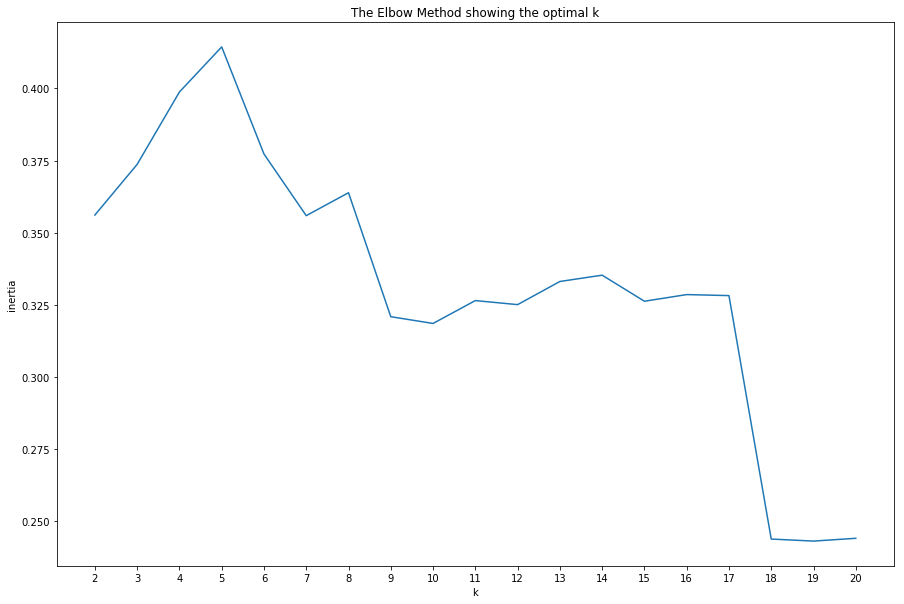

In [17]:
# Тут наиболее явные варианты 5, 8 или 17, остановимся на 5, т.к. в KMeans так же было 5
plt.figure(figsize=(15,10))
plt.plot(K, silhouette)
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k')
plt.xticks(K)
plt.show()

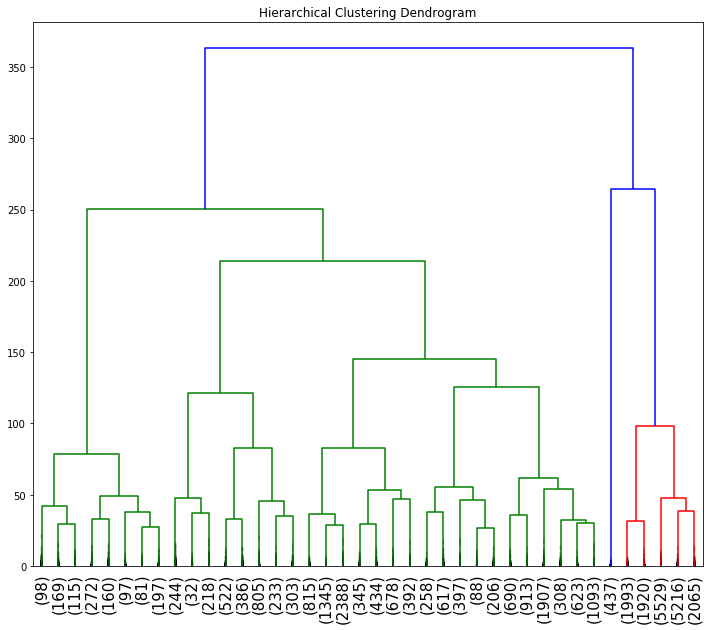

In [18]:
# Построим дендограмму с помощью scipy
linked= hierarchy.linkage(df_group, 'ward')
plt.figure(figsize=(12, 10))
hierarchy.dendrogram(
    linked,
    truncate_mode="lastp",
    p=40, 
    show_leaf_counts=True,
    leaf_rotation=90,
    leaf_font_size=15,
    show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

In [19]:
# На графике дендограммы видно, что расстояние для кластеризации на 5 кластеров равно примерно 150, проверим, что это так
f = hierarchy.fcluster(linked, t=150, criterion='distance')
np.unique(f)
# Получилось 5 кластеров на расстоянии 150

array([1, 2, 3, 4, 5], dtype=int32)

##### DBSCAN:

In [20]:
%%time
eps = np.arange(0.5, 2, 0.1) # коэффициенты eps
min_samples = range(3, 18) # минимальное количество основных точек
union = product(eps, min_samples) # все возможные сочетания коэффициентов
x_eps = []
y_sample = []
z_k = []
Noisy = []
DB = DBSCAN()
pipe.set_params(modelling=DB) # установим модель DBSCAN

# Переберем все сочетания коэффициентов и соберем кол-во получившихся кластеров (без выбросов) и доли выбросов
for i in union: 
    pipe['modelling'].set_params(eps=i[0], min_samples=i[1]).fit(df_group)
    label_with = pipe['modelling'].labels_ # метки кластеров с выбросами
    label_without = np.setdiff1d(label_with, -1) # метки кластеров без выбросов
    x_eps.append(i[0])
    y_sample.append(i[1])
    z_k.append(len(np.unique(label_without)))
    Noisy.append(round(len(label_with[label_with==-1]) / len(label_with), 2))

Wall time: 1h 42min 5s


In [21]:
# Таблица зависимости числа кластеров (К) и доли выбросов (Noisy) от парамтеров eps и min_samples
K = pd.DataFrame({'eps' : x_eps, 'min_samples' : y_sample, 'K' : z_k, 'Noisy' : Noisy})
K.head(60)

,eps,min_samples,K,Noisy
0,0.5,3,102,0.05
1,0.5,4,45,0.06
2,0.5,5,34,0.07
3,0.5,6,18,0.07
4,0.5,7,13,0.08
5,0.5,8,16,0.08
6,0.5,9,17,0.09
7,0.5,10,10,0.09
8,0.5,11,7,0.10
9,0.5,12,6,0.10


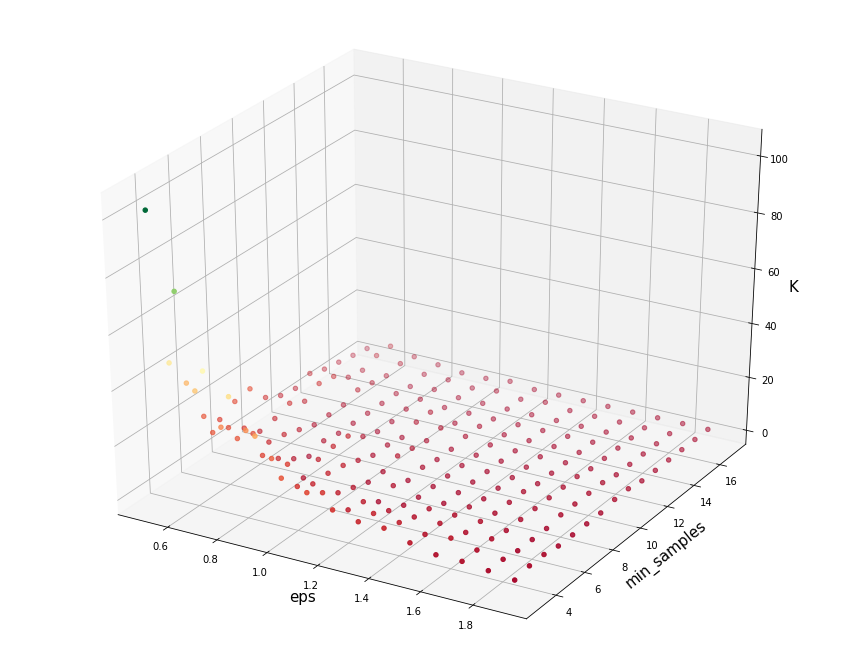

In [22]:
# Построим 3D график разброса зависимости К от eps и min_samples
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_eps, y_sample, z_k, c=z_k,  cmap=plt.cm.RdYlGn)
ax.set_xlabel('eps', size=15) 
ax.set_ylabel('min_samples', size=15) 
ax.set_zlabel('K', size=15) 
ax.tick_params(labelsize=10)
plt.show()
# Число кластеров уменьшается при увеличении радиуса eps и числа основных точек 

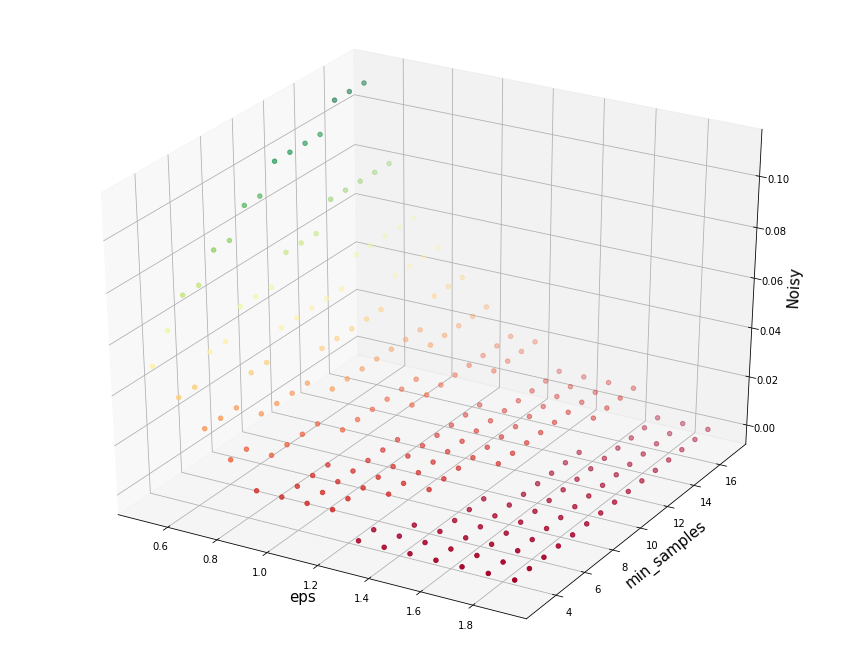

In [23]:
# Построим 3D график разброса зависимости доли выбросов от eps и min_samples
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_eps, y_sample, Noisy, c=Noisy,  cmap=plt.cm.RdYlGn)
ax.set_xlabel('eps', size=15) 
ax.set_ylabel('min_samples', size=15) 
ax.set_zlabel('Noisy', size=15) 
ax.tick_params(labelsize=10)
plt.show()
# Тут зависимость немного другая
# Доля выбросов также уменьшается при увеличении радиуса eps, но при росте основных точек доля выбросов увеличиваются.

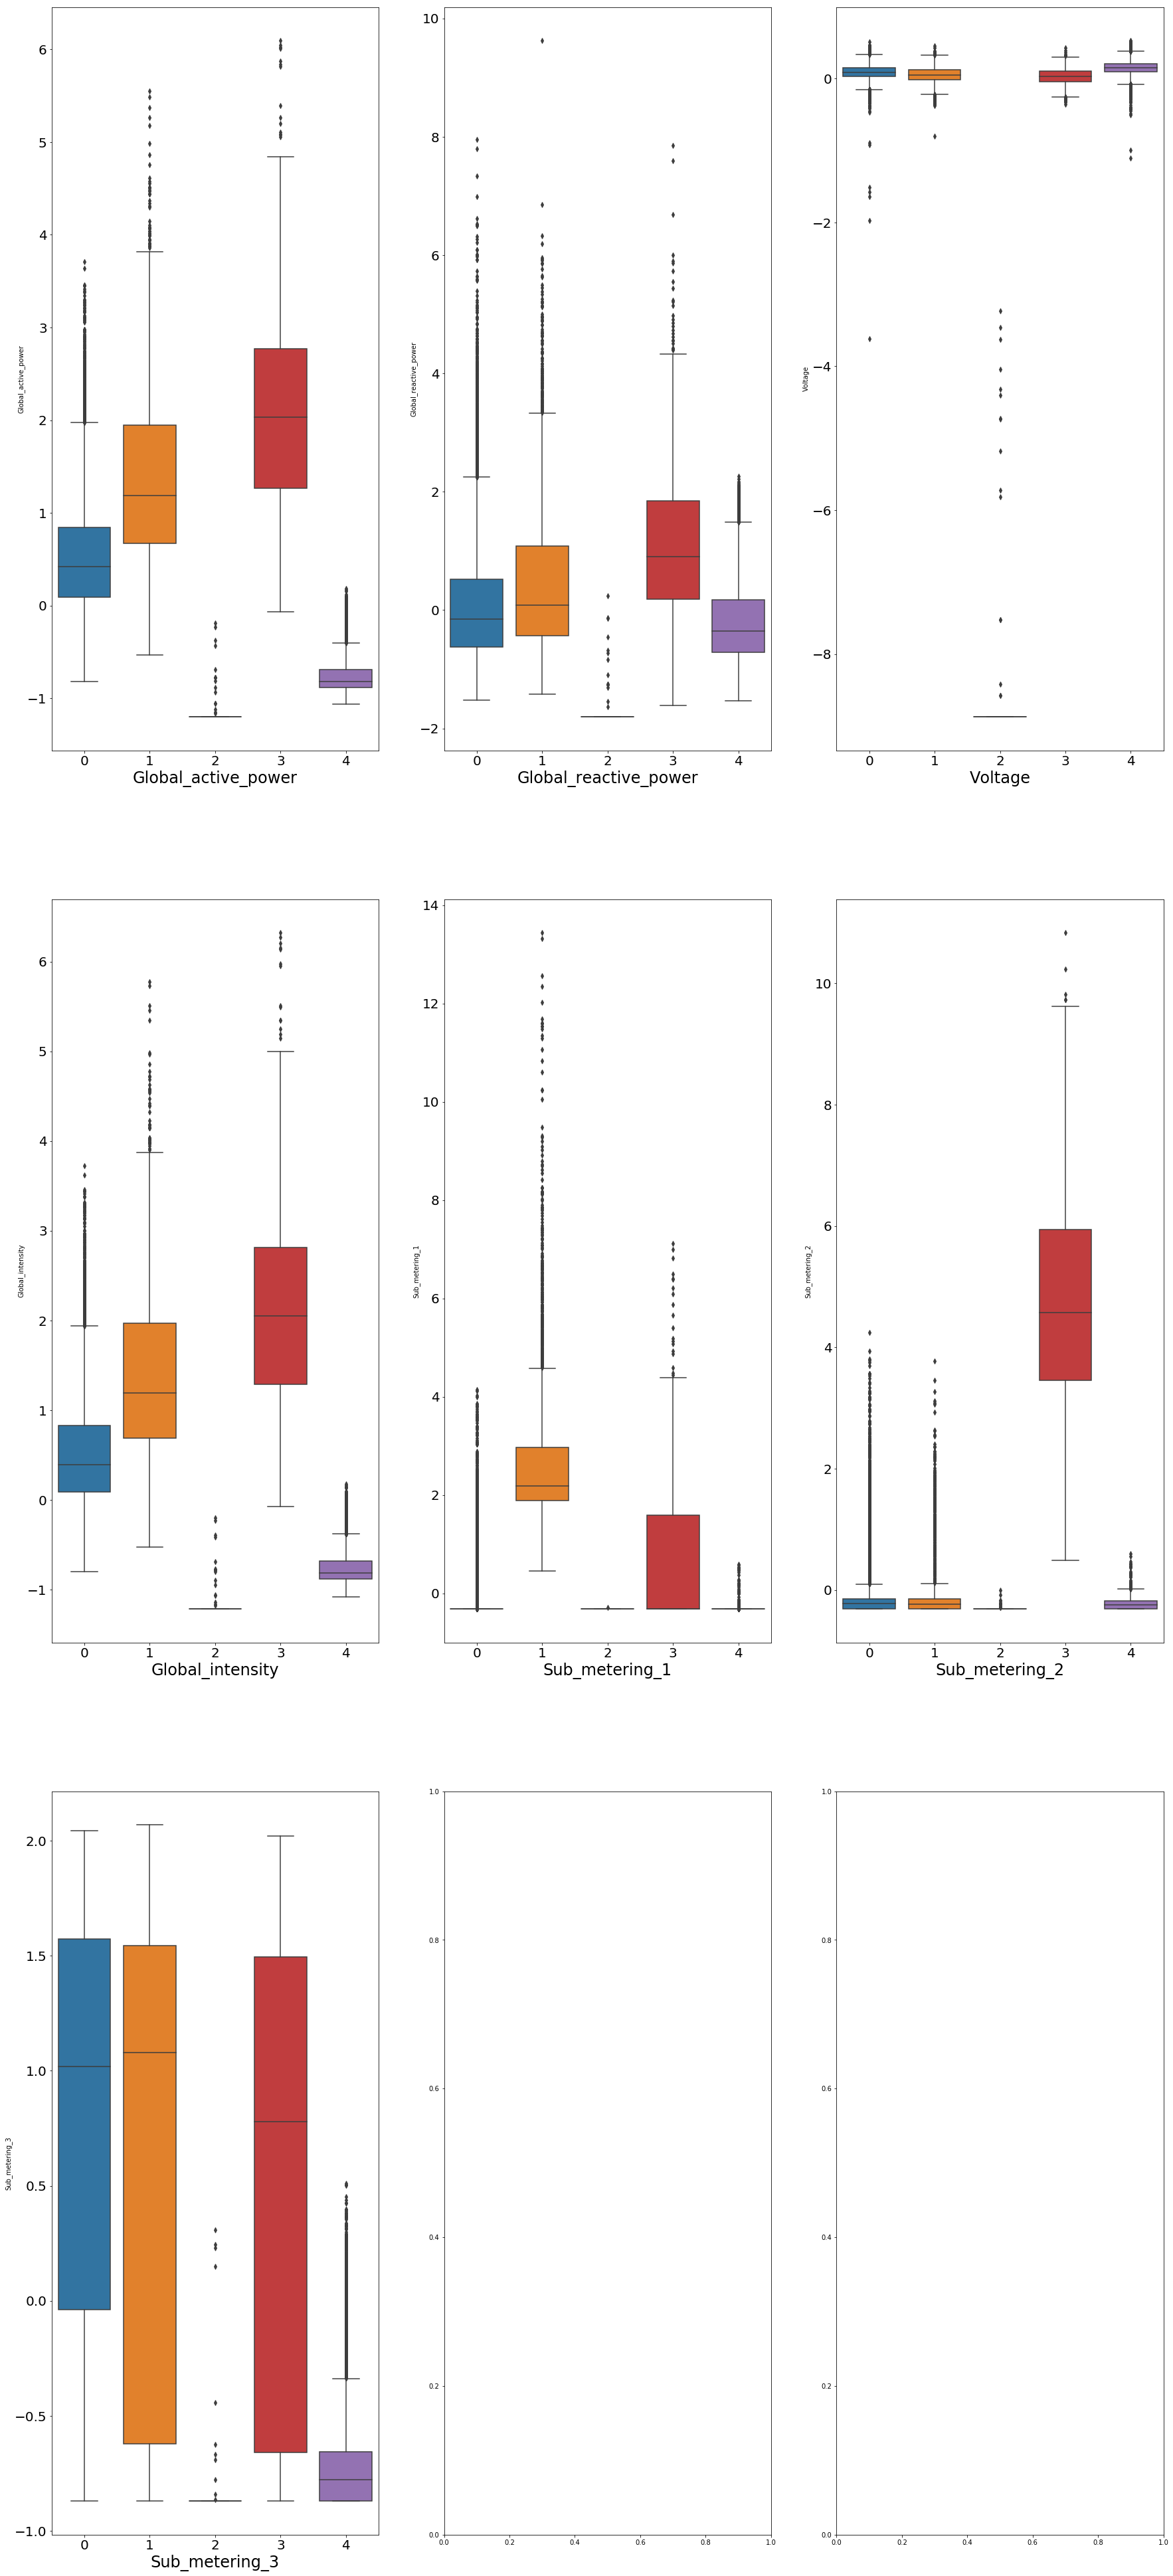

In [24]:
# Сделаем кластеризацию с помощью агломеративной кластеризации с пятью кластерами
pipe.set_params(modelling=AgglomerativeClustering(n_clusters=5))
pipe['modelling'].fit(df_group)
l = pipe['modelling'].labels_

# Посмотрим распределение признаков на каждом из них при пяти кластерах - построим boxplot 
fig, axs = plt.subplots(3, 3, figsize=(30, 70))
j = 0
for i in num_col:
    ax = axs[j//3,j%3]
    ax= sns.boxplot(x=l, y=i, ax=ax, data=pd.DataFrame(df_group, columns=num_col))
    ax.set_xlabel(i, size=24) 
    ax.tick_params(labelsize=20)
    j += 1
# Можно отметить, что на разных кластерах один и тот же признак в осовном распределен по разному, 
# что логично, т.к. кластеры разные

#### Выводы: 
- На основе алгоритмов KMeams и агломеративной кластеризации оптимальное число кластеров - 5;
- Расстояние между кластерами по дендограмме вышло примерно 150 при пяти кластерах;
- Также установлено, что в алгоритме DBSCAN количество кластеров и доля выбросов зависят от параметров eps и min_samples, но не рандомно, а вполне себе закономерно. Так, число кластеров падает при увеличении радиуса и числа основных точек, доля же выбросов наоборот увеличивается при росте основных точек и так же падает при росте радиуса eps.